<a href="https://colab.research.google.com/github/teator/FinEng/blob/main/MLiF/gw3_WQU_MLiF_GroupWork_sub3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---   ---   ---   ---   ---   ---   ---
## WorldQuant University :-: (19/11) MScFE 650 Machine Learning in Finance (C18-S4)
## Group work Assignment  :-:  Timezone Group 2-A  :-: Submission 3

Tea Toradze

January 2020
---   ---   ---   ---   ---   ---   ---

The code adapted from solutions to chapter 3 questions from

*Advances in Financial Machine Learning* by Dr. Marcos Lopez de Prado

as provided in  https://github.com/hudson-and-thames/research/tree/master/Chapter3

---



In [ ]:
# Installing necessary packages
!pip install pyfolio

In [ ]:
!pip install mlfinlab


In [ ]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install

--2020-01-07 13:04:10--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-01-07 13:04:11--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://astuteinternet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2020-01-07 13:04:11--  https://astuteinternet.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving as

In [ ]:
!pip install ta-lib



In [ ]:
# Importing working packages

import mlfinlab as ml

import numpy as np
import pandas as pd
import pyfolio as pf
import talib as ta
import timeit

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from sklearn.utils import resample
from sklearn.utils import shuffle

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline



/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [ ]:
# Read in data
data = pd.read_csv('https://raw.githubusercontent.com/teator/WQU-MLiF/master/dollar_bars.csv')
data.index = pd.to_datetime(data['date'])
data = data.drop('date', axis=1)



---
### Fit a Primary Model: Trend Following
Based on the simple moving average cross-over strategy.


In [ ]:
# compute moving averages
fast_window = 2
slow_window = 5

data['fast_mavg'] = data['close'].rolling(window=fast_window,
                                          min_periods=fast_window, center=False).mean()
data['slow_mavg'] = data['close'].rolling(window=slow_window,
                                          min_periods=slow_window, center=False).mean()

# Compute sides
data['side'] = np.nan
long_signals = data['fast_mavg'] >= data['slow_mavg']
short_signals = data['fast_mavg'] < data['slow_mavg']
data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

# Remove Look ahead biase by lagging the signal
data['side'] = data['side'].shift(1)



In [ ]:
# Save the raw data
raw_data = data.copy()

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)


In [ ]:
data['side'].value_counts()



 1.0    536
-1.0    483
Name: side, dtype: int64

### Filter Events: CUSUM Filter
Predict what will happen when a CUSUM event is triggered.

Use the signal from the MAvg Strategy to determine the side of the bet.

In [ ]:
# Compute daily volatility
daily_vol = ml.util.get_daily_vol(close=data['close'], lookback=2)

# Apply Symmetric CUSUM Filter and get timestamps for events
cusum_events = ml.filters.cusum_filter(data['close'],
                                       threshold=daily_vol['2013-09-01':'2013-09-15'].mean()*0.5)

# Compute vertical barrier
vertical_barriers = ml.labeling.add_vertical_barrier(t_events=cusum_events,
                                                     close=data['close'], num_days=1)


In [ ]:
pt_sl = [1, 2]
min_ret = 0.0001
triple_barrier_events = ml.labeling.get_events(close=data['close'],
                                               t_events=cusum_events,
                                               pt_sl=pt_sl,
                                               target=daily_vol,
                                               min_ret=min_ret,
                                               num_threads=3,
                                               vertical_barrier_times=vertical_barriers,
                                               side_prediction=data['side'])


/usr/local/lib/python3.6/dist-packages/mlfinlab/labeling/labeling.py:124: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  target = target.loc[t_events]
2020-01-07 13:05:21.141027 100.0% apply_pt_sl_on_t1 done after 0.02 minutes. Remaining 0.0 minutes.


In [ ]:
labels = ml.labeling.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()



 1.0    314
-1.0    278
Name: side, dtype: int64

### Results of Primary Model:
The precision, recall, and F1-scores.

In [ ]:
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(actual, pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))



              precision    recall  f1-score   support

           0       0.00      0.00      0.00       248
           1       0.58      1.00      0.74       344

    accuracy                           0.58       592
   macro avg       0.29      0.50      0.37       592
weighted avg       0.34      0.58      0.43       592

Confusion Matrix
[[  0 248]
 [  0 344]]

Accuracy
0.581081081081081


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



---
### Fit a Meta Model


**Features**

In [ ]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
raw_data['volatility_1'] = raw_data['log_ret'].rolling(window=1, min_periods=1, center=False).std()
raw_data['volatility_2'] = raw_data['log_ret'].rolling(window=2, min_periods=2, center=False).std()
raw_data['volatility_3'] = raw_data['log_ret'].rolling(window=3, min_periods=3, center=False).std()
raw_data['volatility_4'] = raw_data['log_ret'].rolling(window=4, min_periods=4, center=False).std()
raw_data['volatility_5'] = raw_data['log_ret'].rolling(window=5, min_periods=5, center=False).std()

# Serial Correlation
window_autocorr = 3

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr,
                                                     min_periods=window_autocorr,
                                                     center=False).apply(lambda x: x.autocorr(lag=1),
                                                                         raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr,
                                                     min_periods=window_autocorr,
                                                     center=False).apply(lambda x: x.autocorr(lag=2),
                                                                         raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr,
                                                     min_periods=window_autocorr,
                                                     center=False).apply(lambda x: x.autocorr(lag=3),
                                                                         raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr,
                                                     min_periods=window_autocorr,
                                                     center=False).apply(lambda x: x.autocorr(lag=4),
                                                                         raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr,
                                                     min_periods=window_autocorr,
                                                     center=False).apply(lambda x: x.autocorr(lag=5),
                                                                         raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)



/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)


In [ ]:
# Adding more indicators

# Exponential Moving Average
raw_data['EMA2'] = ta.EMA(raw_data['close'].values, timeperiod=2)
raw_data['EMA5'] = ta.EMA(raw_data['close'].values, timeperiod=5)

# Average True Range
raw_data['ATR2'] = ta.ATR(raw_data['high'].values,
                          raw_data['low'].values, raw_data['close'].values, timeperiod=2)
raw_data['ATR5'] = ta.ATR(raw_data['high'].values,
                          raw_data['low'].values, raw_data['close'].values, timeperiod=5)
raw_data['ATR14'] = ta.ATR(raw_data['high'].values,
                           raw_data['low'].values, raw_data['close'].values, timeperiod=14)

# Average Directional Movement Index
raw_data['ADX2'] = ta.ADX(raw_data['high'].values,
                          raw_data['low'].values, raw_data['close'].values, timeperiod=2)
raw_data['ADX5'] = ta.ADX(raw_data['high'].values,
                          raw_data['low'].values, raw_data['close'].values, timeperiod=5)
raw_data['ADX14'] = ta.ADX(raw_data['high'].values,
                           raw_data['low'].values, raw_data['close'].values, timeperiod=14)

# Relative Strength Index
raw_data['RSI2'] = ta.RSI(raw_data['close'].values, timeperiod=2)
raw_data['RSI5'] = ta.RSI(raw_data['close'].values, timeperiod=5)
raw_data['RSI14'] = ta.RSI(raw_data['close'].values, timeperiod=14)

# Moving Average Convergence/Divergence
macd, macdsignal, macdhist = ta.MACD(raw_data['close'].values,
                                     fastperiod=5, slowperiod=2, signalperiod=3)
raw_data['MACD'] = macd
raw_data['MACDsignal'] = macdsignal



In [ ]:
raw_data.fillna(0, inplace=True)
raw_data.drop(['close'], axis=1)

# Log transformation and normalization
raw_data['log_trnsf'] = (raw_data['close']-raw_data['close'].min()+1).transform(np.log)
raw_data['normalized'] = (raw_data['close'] - raw_data['close'].min()) / (raw_data['close'].max() - raw_data['close'].min())

# Predictors for the averages and the MACD
raw_data['CLgtEMA2'] = np.where(raw_data['close'] > raw_data['EMA2'], 1, -1)
raw_data['EMA2gtEMA5'] = np.where(raw_data['EMA2'] > raw_data['EMA5'], 1, -1)
raw_data['MACDSIGgtMACD'] = np.where(raw_data['MACDsignal'] > raw_data['MACD'], 1, -1)



In [ ]:
# Re compute sides
raw_data['side'] = np.nan
long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1


In [ ]:
# Remove look ahead bias
raw_data = raw_data.shift(1)



**Now get the data at the specified events**

In [ ]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['open', 'high', 'low', 'close', 'volume', 'vwap', 'fast_mavg', 'slow_mavg',],
       axis=1, inplace=True)

y = labels['bin']
y.value_counts()



1    344
0    248
Name: bin, dtype: int64

**Balance classes**

In [ ]:
# Split data into training, validation and test sets
X_training_validation = X['2013-09-01':'2013-09-15']
y_training_validation = y['2013-09-01':'2013-09-15']

X_train, X_validate, y_train, y_validate = train_test_split(X_training_validation,
                                                            y_training_validation,
                                                            test_size=0.2,
                                                            shuffle=False)


In [ ]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()


1    189
0    115
Name: bin, dtype: int64

In [ ]:
# Upsample the training data to have a 50 - 50 split
# https://elitedatascience.com/imbalanced-classes
majority = train_df[train_df['bin'] == 0]
minority = train_df[train_df['bin'] == 1]

new_minority = resample(minority,
                   replace=True,     # sample with replacement
                   n_samples=majority.shape[0],    # to match majority class
                   random_state=42)

train_df = pd.concat([majority, new_minority])
train_df = shuffle(train_df, random_state=42)

train_df['bin'].value_counts()


1    115
0    115
Name: bin, dtype: int64

In [ ]:
# clearing NaN data
train_df = train_df.dropna(how='any', axis=0)


In [ ]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']



**Fit a model:** train a random forest

In [ ]:
parameters = {'max_depth':[2, 3, 4, 5, 6, 7, 8],
              'n_estimators':[1, 10, 25, 50, 100, 256, 512],
              'random_state':[42]}

def perform_grid_search(X_data, y_data):
    rf = RandomForestClassifier(criterion='entropy')
    clf = GridSearchCV(rf, parameters, cv=5, scoring='roc_auc', n_jobs=3)
    clf.fit(X_data, y_data)
    print(clf.cv_results_['mean_test_score'])
    return clf.best_params_['n_estimators'], clf.best_params_['max_depth']


In [ ]:
# extract parameters
n_estimator, depth = perform_grid_search(X_train, y_train)
c_random_state = 42
print(n_estimator, depth, c_random_state)


[0.60075614 0.62741021 0.64839319 0.64801512 0.64952741 0.64877127
 0.64574669 0.61928166 0.63459357 0.66427221 0.66086957 0.67032136
 0.65897921 0.65822306 0.56427221 0.636862   0.65028355 0.663138
 0.67750473 0.6831758  0.6831758  0.55822306 0.64763705 0.68657845
 0.68620038 0.68620038 0.68960302 0.69187146 0.60548204 0.67013233
 0.69111531 0.69640832 0.68620038 0.6899811  0.69376181 0.5979206
 0.6657845  0.71304348 0.70396975 0.71077505 0.6979206  0.70321361
 0.57712665 0.64820416 0.69867675 0.7194707  0.7073724  0.70094518
 0.70623819]
50 8 42


In [ ]:
# Refit a new model with best params, so we can see feature importance
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator,
                            criterion='entropy', random_state=c_random_state)

rf.fit(X_train, y_train.values.ravel())



RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


---
### Training Metrics

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       115
           1       1.00      0.98      0.99       115

    accuracy                           0.99       230
   macro avg       0.99      0.99      0.99       230
weighted avg       0.99      0.99      0.99       230

Confusion Matrix
[[115   0]
 [  2 113]]

Accuracy
0.991304347826087


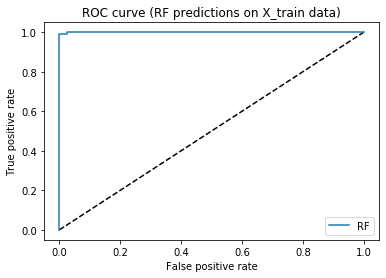

In [ ]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_train)[:, 1]
y_pred = rf.predict(X_train)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_pred_rf)
print(classification_report(y_train, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_train, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_train, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (RF predictions on X_train data)')
plt.legend(loc='best')
plt.show()



### Validation Metrics

              precision    recall  f1-score   support

           0       0.48      0.78      0.60        37
           1       0.50      0.21      0.29        39

    accuracy                           0.49        76
   macro avg       0.49      0.49      0.44        76
weighted avg       0.49      0.49      0.44        76

Confusion Matrix
[[29  8]
 [31  8]]

Accuracy
0.4868421052631579


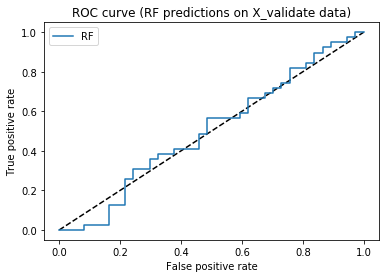

In [ ]:
# Meta-label
# Performance Metrics
y_pred_rf = rf.predict_proba(X_validate)[:, 1]
y_pred = rf.predict(X_validate)
fpr_rf, tpr_rf, _ = roc_curve(y_validate, y_pred_rf)
print(classification_report(y_validate, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_validate, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_validate, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (RF predictions on X_validate data)')
plt.legend(loc='best')
plt.show()



In [ ]:
print(X_validate.index.min())
print(X_validate.index.max())



2013-09-11 09:27:59.127000
2013-09-15 21:52:39.489000


In [ ]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

start = primary_forecast.index.get_loc('2013-09-11 09:27:59.127000')
end = primary_forecast.index.get_loc('2013-09-15 21:52:39.489000') + 1

subset_prim = primary_forecast[start : end]

# Performance Metrics for subset-primary
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(actual, pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.51      1.00      0.68        39

    accuracy                           0.51        76
   macro avg       0.26      0.50      0.34        76
weighted avg       0.26      0.51      0.35        76

Confusion Matrix
[[ 0 37]
 [ 0 39]]

Accuracy
0.5131578947368421


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


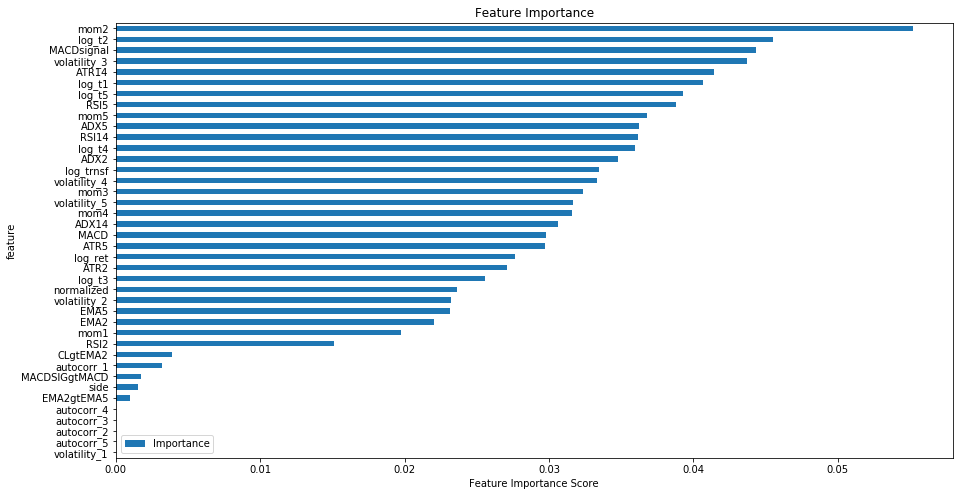

In [ ]:
# Feature Importance
feat_imp = pd.DataFrame({'Importance':rf.feature_importances_})
feat_imp['feature'] = X.columns
feat_imp.sort_values(by='Importance', ascending=False, inplace=True)
feat_imp = feat_imp

feat_imp.sort_values(by='Importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title='Feature Importance', figsize=(15, 8))
plt.xlabel('Feature Importance Score')
plt.show()




---
### Performance Tear Sheets (In-sample)

**Without Meta Labeling**

In [ ]:
def get_daily_returns(intraday_returns):  # This changes returns into daily returns
    cum_rets = ((intraday_returns + 1).cumprod())
    daily_rets = cum_rets.resample('B').last()
    daily_rets = daily_rets.ffill().pct_change().dropna()
    return daily_rets


In [ ]:
valid_dates = X_validate.index
base_rets = labels.loc[valid_dates, 'ret']
primary_model_rets = get_daily_returns(base_rets)


In [ ]:
# Set-up the function to extract the KPIs from pyfolio
perf_func = pf.timeseries.perf_stats


In [ ]:
# Save the statistics in a dataframe
perf_stats_all = perf_func(returns=primary_model_rets,
                           factor_returns=None,
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")
perf_stats_df = pd.DataFrame(data=perf_stats_all, columns=['Primary Model'])

pf.show_perf_stats(primary_model_rets)



Start date,2013-09-12
End date,2013-09-13
Total months,0
,Backtest
Annual return,73.7%
Cumulative returns,0.4%
Annual volatility,32.2%
Sharpe ratio,1.80
Calmar ratio,61.22
Stability,1.00
Max drawdown,-1.2%


**With Meta Labeling**

In [ ]:
meta_returns = labels.loc[valid_dates, 'ret'] * y_pred
daily_meta_rets = get_daily_returns(meta_returns)


In [ ]:
# Save the KPIs in a dataframe
perf_stats_df['Meta Model']  = perf_func(returns=daily_meta_rets,
                           factor_returns=None,
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")


pf.show_perf_stats(daily_meta_rets)



Start date,2013-09-12
End date,2013-09-13
Total months,0
,Backtest
Annual return,-63.2%
Cumulative returns,-0.8%
Annual volatility,30.4%
Sharpe ratio,-3.21
Calmar ratio,-36.31
Stability,1.00
Max drawdown,-1.7%


---
### Performance Tear Sheets (Out-of-sample)

**Meta Model Metrics**

In [ ]:
# Extarct data for out-of-sample (OOS)
X_oos = X['2013-09-16':]
y_oos = y['2013-09-16':]


              precision    recall  f1-score   support

           0       0.46      0.77      0.58        96
           1       0.58      0.26      0.36       116

    accuracy                           0.49       212
   macro avg       0.52      0.51      0.47       212
weighted avg       0.53      0.49      0.46       212

Confusion Matrix
[[74 22]
 [86 30]]

Accuracy
0.49056603773584906


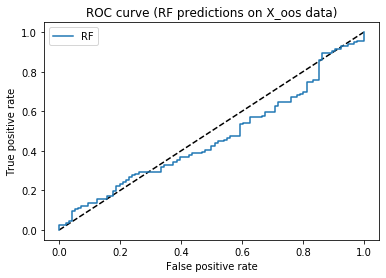

In [ ]:
# Performance Metrics
y_pred_rf = rf.predict_proba(X_oos)[:, 1]
y_pred = rf.predict(X_oos)
fpr_rf, tpr_rf, _ = roc_curve(y_oos, y_pred_rf)
print(classification_report(y_oos, y_pred))

print("Confusion Matrix")
print(confusion_matrix(y_oos, y_pred))

print('')
print("Accuracy")
print(accuracy_score(y_oos, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (RF predictions on X_oos data)')
plt.legend(loc='best')
plt.show()



In [ ]:
# Primary model
primary_forecast = pd.DataFrame(labels['bin'])
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

subset_prim = primary_forecast['2013-09-16':]

# Performance Metrics
actual = subset_prim['actual']
pred = subset_prim['pred']
print(classification_report(actual, pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        96
           1       0.55      1.00      0.71       116

    accuracy                           0.55       212
   macro avg       0.27      0.50      0.35       212
weighted avg       0.30      0.55      0.39       212

Confusion Matrix
[[  0  96]
 [  0 116]]

Accuracy
0.5471698113207547


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Primary Model (Test Data)**

Start date,2013-09-16
End date,2013-09-20
Total months,10
,Backtest
Annual return,1.6%
Cumulative returns,1.3%
Annual volatility,3.1%
Sharpe ratio,0.51
Calmar ratio,0.59
Stability,0.36
Max drawdown,-2.6%


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,2.64,2013-09-16,2013-09-17,2013-09-18,3
1,1.91,2013-09-18,2013-09-20,NaT,NaN
2,0.40,2013-09-16,2013-09-16,2013-09-16,1
3,0.28,2013-09-18,2013-09-18,2013-09-18,1
4,0.26,2013-09-18,2013-09-18,2013-09-18,1


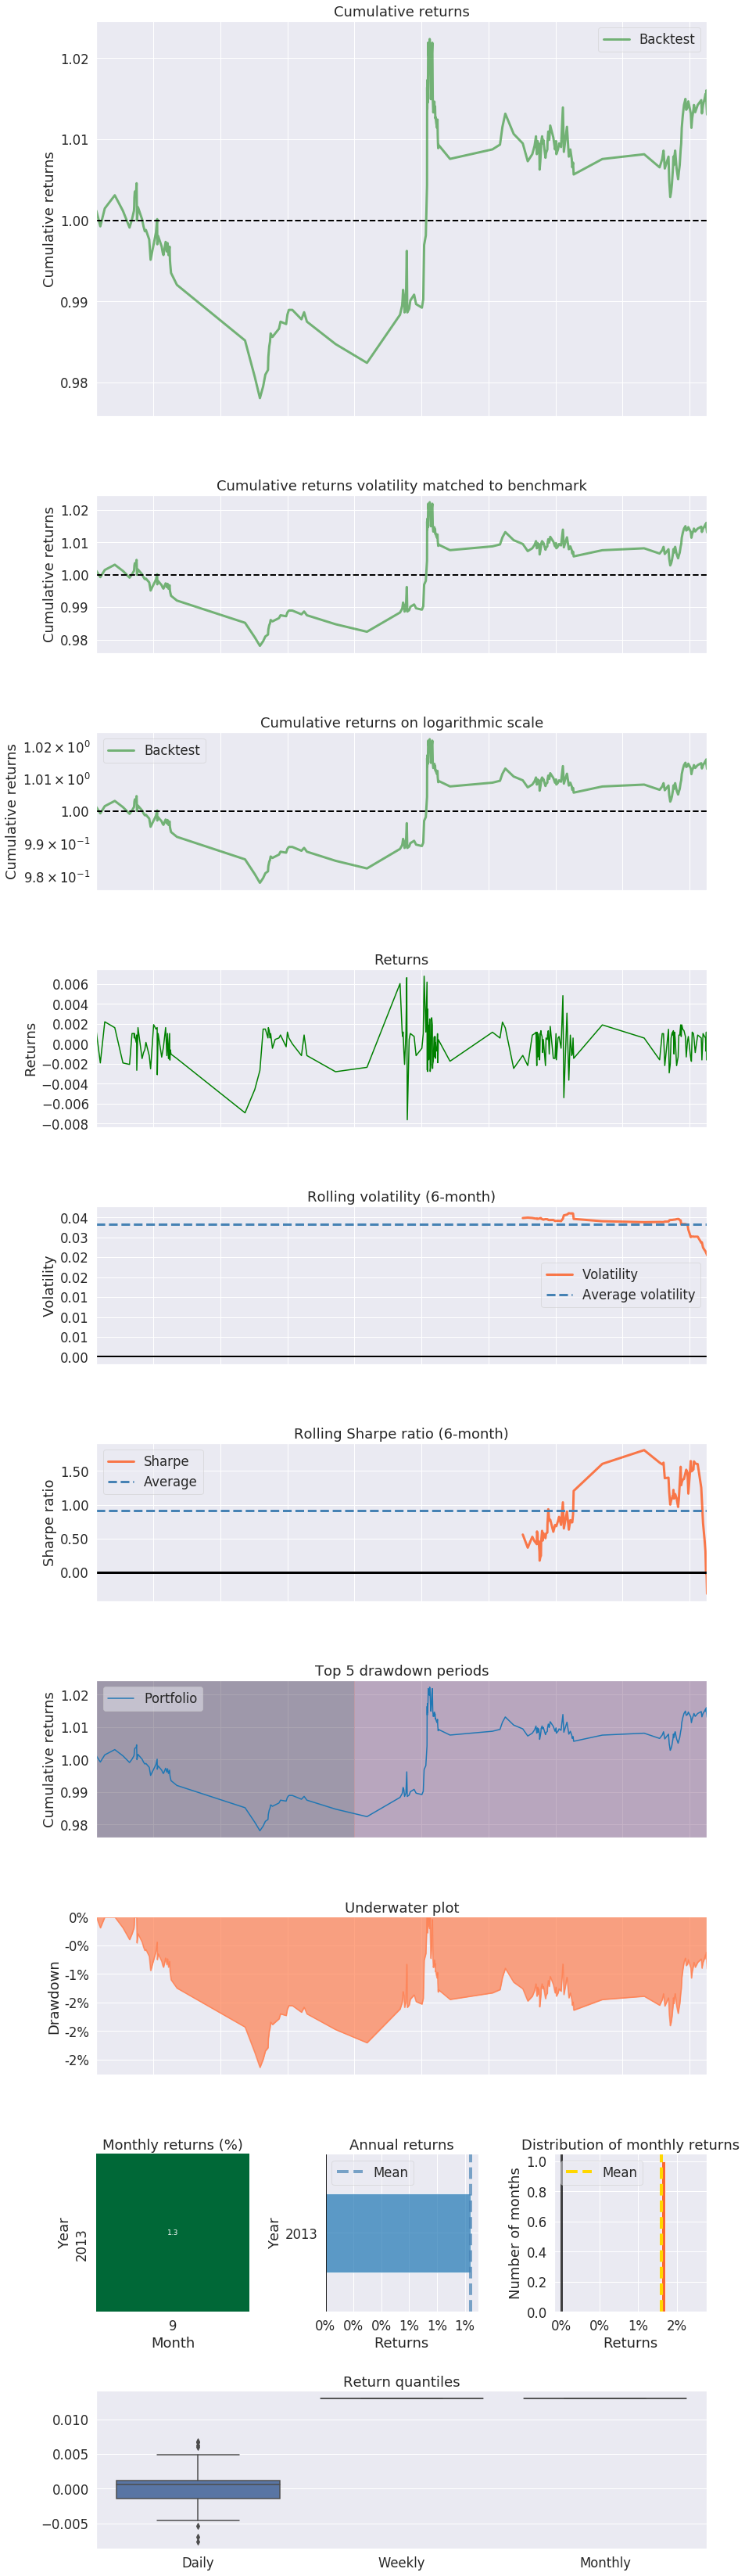

In [ ]:
# without downsampling
test_dates = X_oos.index
prim_rets_test = labels.loc[test_dates, 'ret']
pf.create_returns_tear_sheet(prim_rets_test, benchmark_rets=None)



Start date,2013-09-17
End date,2013-09-20
Total months,0
,Backtest
Annual return,273.9%
Cumulative returns,2.1%
Annual volatility,20.7%
Sharpe ratio,6.48
Calmar ratio,372.40
Stability,0.76
Max drawdown,-0.7%


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.00,2013-09-18,2013-09-19,2013-09-20,3
1,0.00,2013-09-17,2013-09-17,2013-09-17,1
2,0.00,2013-09-17,2013-09-17,2013-09-17,1
3,0.00,2013-09-17,2013-09-17,2013-09-17,1
4,0.00,2013-09-17,2013-09-17,2013-09-17,1


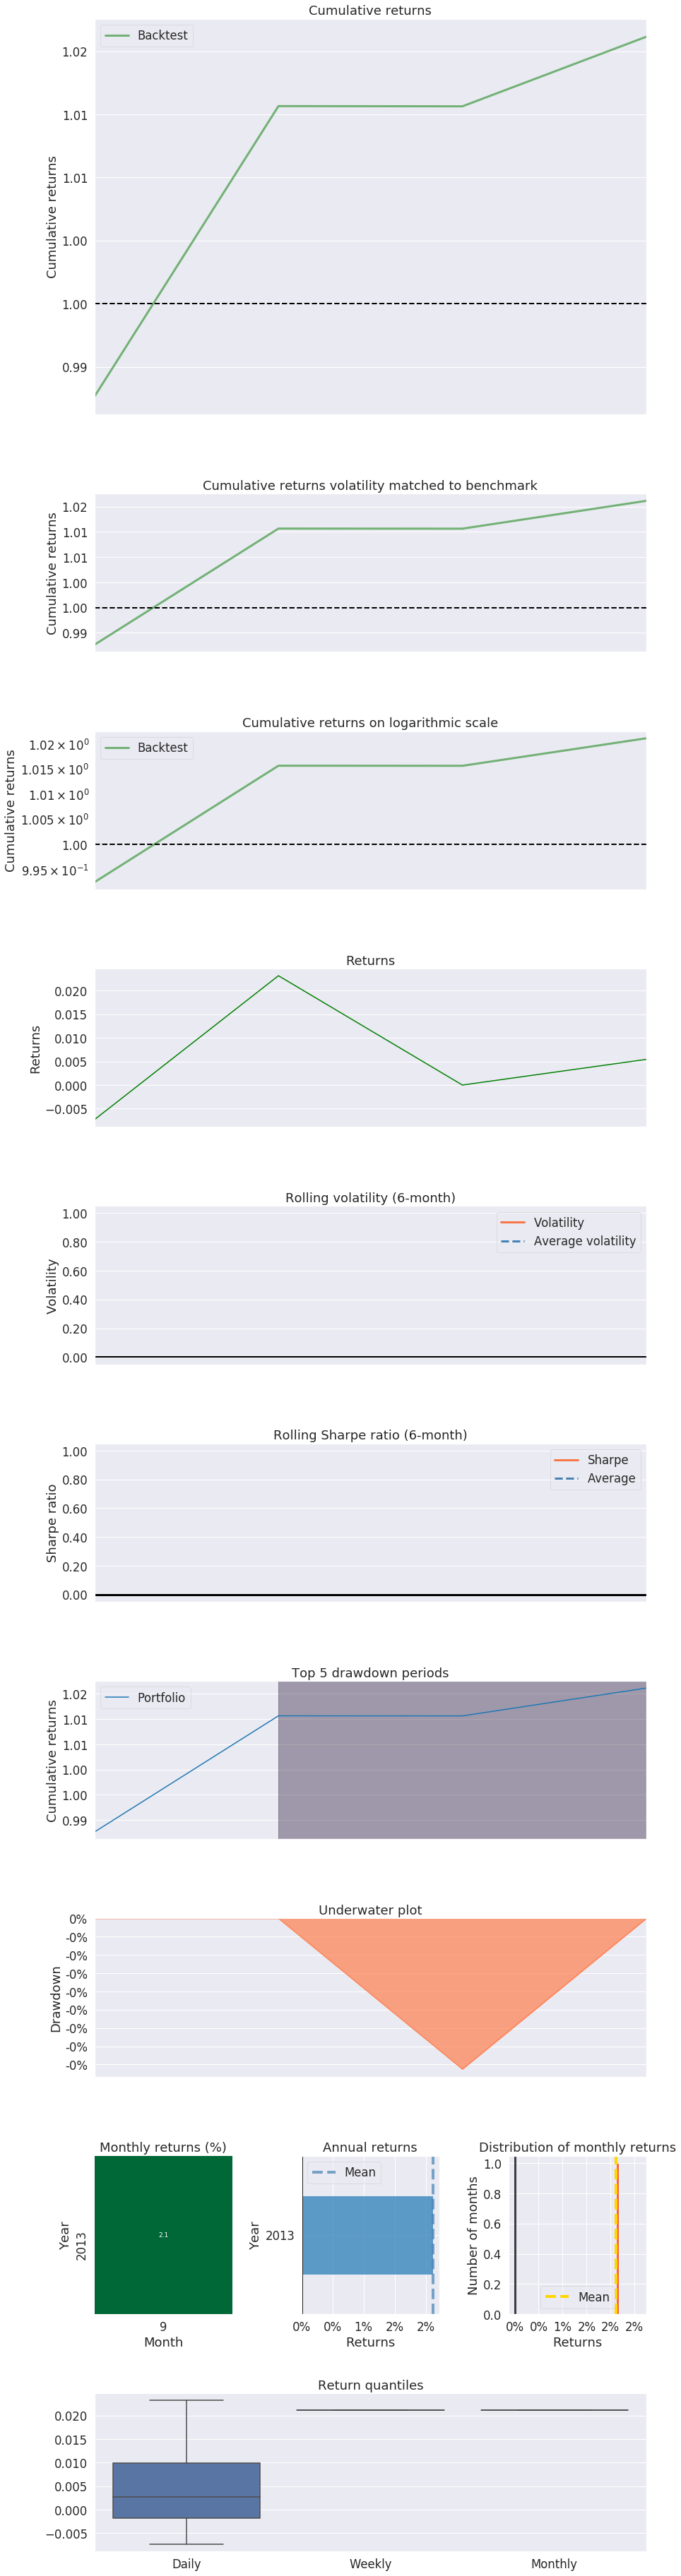

In [ ]:
# Downsample to daily
test_dates = X_oos.index
prim_rets_test = labels.loc[test_dates, 'ret']
daily_rets_prim = get_daily_returns(prim_rets_test)

# Save the statistics in a dataframe
perf_stats_df['Primary Model OOS'] = perf_func(returns=daily_rets_prim,
                           factor_returns=None,
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

# Create tear sheet
pf.create_returns_tear_sheet(daily_rets_prim, benchmark_rets=None)



**Meta Model (Test Data)**

Start date,2013-09-16
End date,2013-09-20
Total months,10
,Backtest
Annual return,2.9%
Cumulative returns,2.4%
Annual volatility,1.8%
Sharpe ratio,1.62
Calmar ratio,2.83
Stability,0.66
Max drawdown,-1.0%


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,1.03,2013-09-18,2013-09-20,NaT,NaN
1,0.51,2013-09-17,2013-09-18,2013-09-18,1
2,0.40,2013-09-16,2013-09-16,2013-09-17,2
3,0.31,2013-09-18,2013-09-18,2013-09-18,1
4,0.26,2013-09-18,2013-09-18,2013-09-18,1


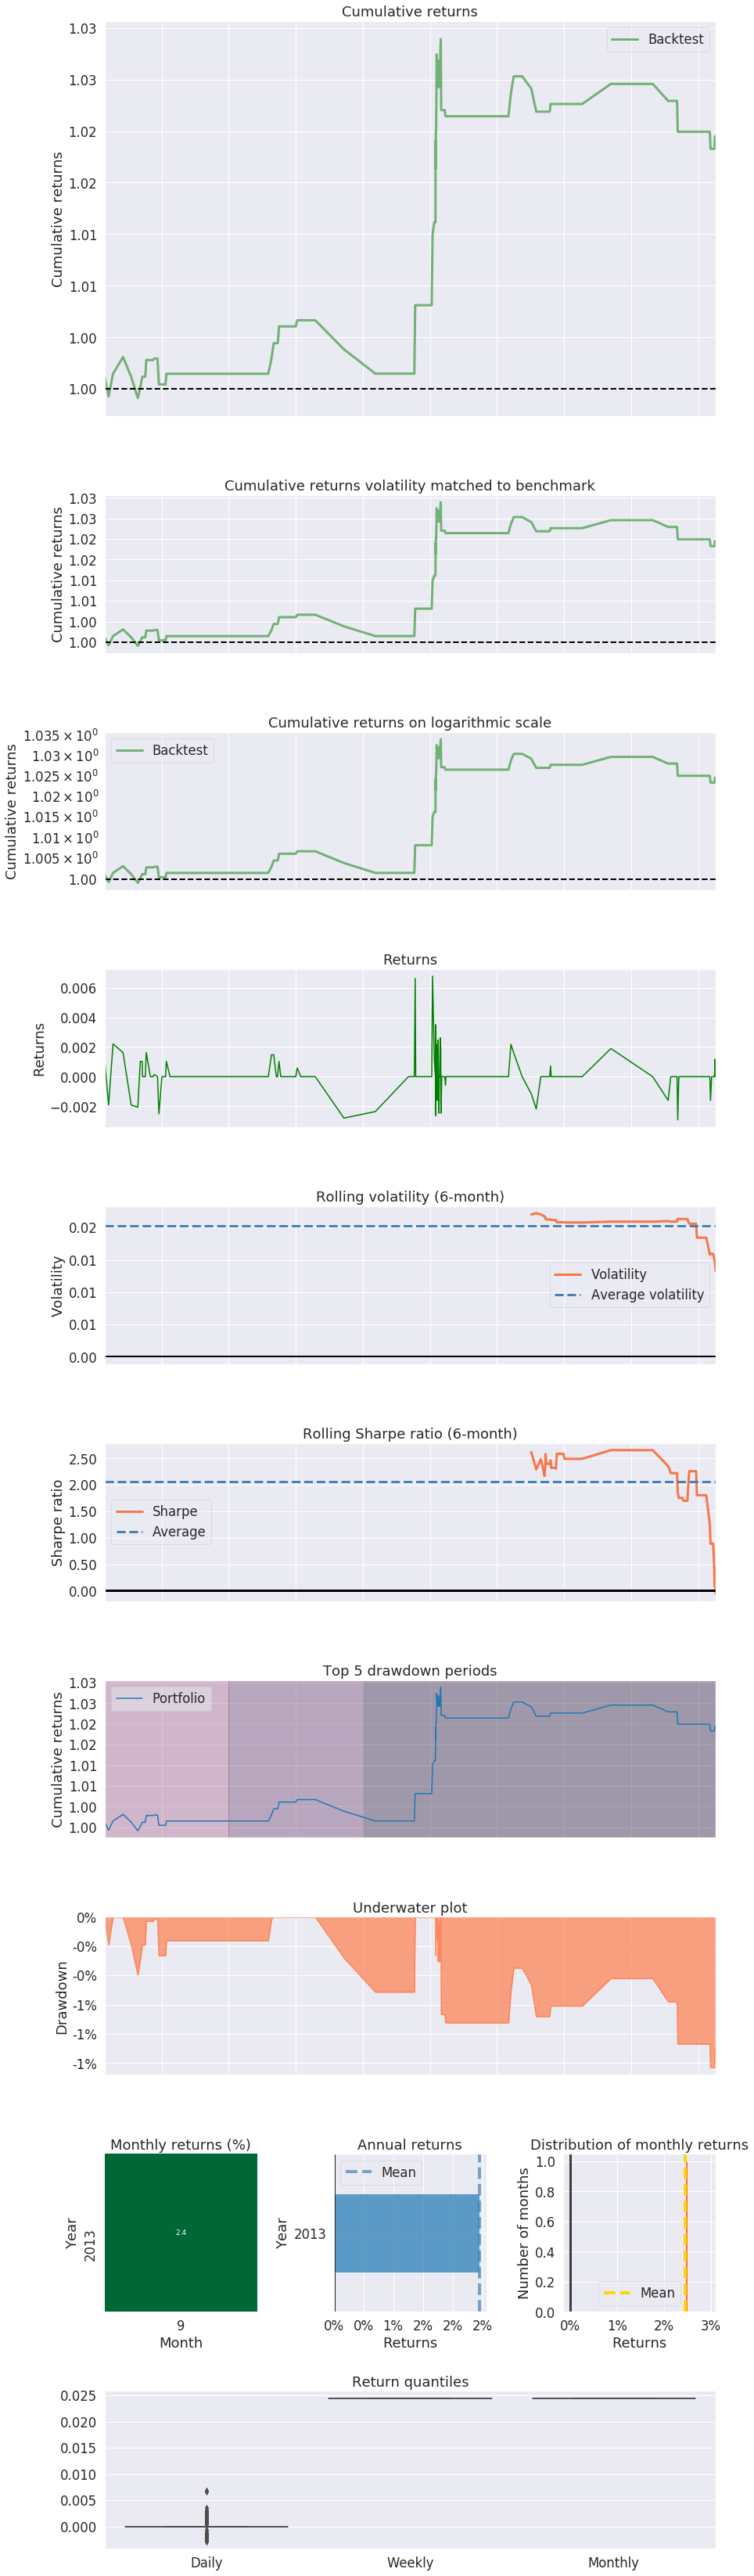

In [ ]:
# without downsampling
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
pf.create_returns_tear_sheet(meta_returns, benchmark_rets=None)



Start date,2013-09-17
End date,2013-09-20
Total months,0
,Backtest
Annual return,318.5%
Cumulative returns,2.3%
Annual volatility,18.6%
Sharpe ratio,7.77
Calmar ratio,644.29
Stability,0.52
Max drawdown,-0.5%


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,0.49,2013-09-19,2013-09-20,NaT,NaN
1,0.00,2013-09-17,2013-09-17,2013-09-17,1
2,0.00,2013-09-17,2013-09-17,2013-09-17,1
3,0.00,2013-09-17,2013-09-17,2013-09-17,1
4,0.00,2013-09-17,2013-09-17,2013-09-17,1


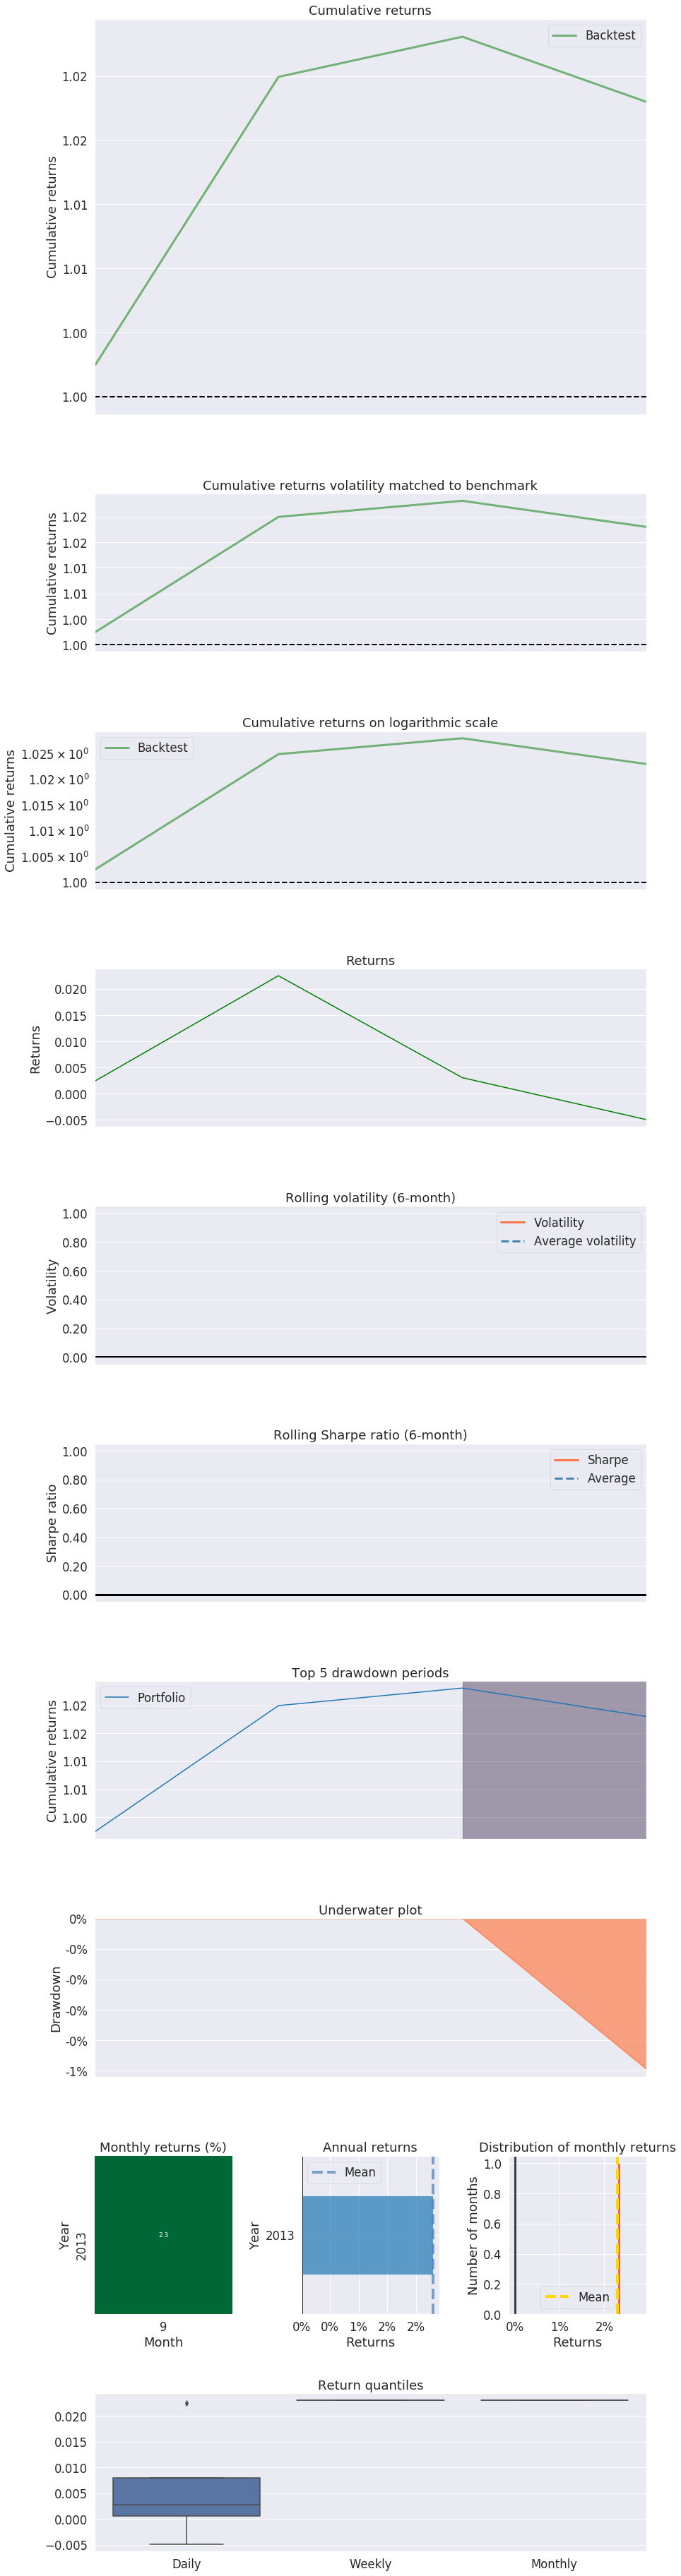

In [ ]:
# Downsample to daily
meta_returns = labels.loc[test_dates, 'ret'] * y_pred
daily_rets_meta = get_daily_returns(meta_returns)

# save the KPIs in a dataframe
perf_stats_df['Meta Model OOS'] = perf_func(returns=daily_rets_meta,
                           factor_returns=None,
                           positions=None,
                           transactions=None,
                           turnover_denom="AGB")

# Create tear sheet
pf.create_returns_tear_sheet(daily_rets_meta, benchmark_rets=None)

